In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Scale data:

MinMaxScaler (normalization) scales your data to a specific range, typically [0, 1] or [-1, 1]. 
It's useful when you want to constrain the features within a specific range and when you don't want to 
assume a normal distribution of the data. This is a good choice when the absolute values and the relative 
relationships between your features are important.

In [2]:
# Define the data types as a dictionary
dtypes = {
    'census_tract': 'float32',
    'action_taken': 'int32',
    'loan_type': 'int32',
    'lien_status': 'int32',
    'reverse_mortgage': 'int32',
    'open_end_line_of_credit': 'int32',
    'loan_amount': 'int32',
    'combined_loan_to_value_ratio': 'int32',
    'interest_rate': 'float32',
    'total_loan_costs': 'int32',
    'origination_charges': 'int32',
    'loan_term': 'int32',
    'negative_amortization': 'int32',
    'interest_only_payment': 'int32',
    'balloon_payment': 'int32',
    'other_nonamortizing_features': 'int32',
    'property_value': 'float32',
    'occupancy_type': 'int32',
    'manufactured_home_secured_property_type': 'int32',
    'manufactured_home_land_property_interest': 'int32',
    'total_units': 'int32',
    'income': 'float32',
    'debt_to_income_ratio': 'int32',
    'applicant_credit_score_type': 'int32',
    'co_applicant_credit_score_type': 'int32',
    'applicant_sex': 'int32',
    'co_applicant_sex': 'int32',
    'applicant_age': 'int32',
    'co_applicant_age': 'int32',
    'aus_1': 'int32',
    'applicant_race_1': 'float32',
    'applicant_race_2': 'float32',
    'co_applicant_race_1': 'float32',
    'co_applicant_race_2': 'float32',
    'applicant_ethnicity_1': 'float32',
    'co_applicant_ethnicity_1': 'float32'
}

In [3]:
# Read the CSV file with specified data types
df = pd.read_csv('10_all_numerical_32bit.csv', dtype=dtypes, low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148621 entries, 0 to 148620
Data columns (total 36 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   census_tract                              148621 non-null  float32
 1   action_taken                              148621 non-null  int32  
 2   loan_type                                 148621 non-null  int32  
 3   lien_status                               148621 non-null  int32  
 4   reverse_mortgage                          148621 non-null  int32  
 5   open_end_line_of_credit                   148621 non-null  int32  
 6   loan_amount                               148621 non-null  int32  
 7   combined_loan_to_value_ratio              148621 non-null  int32  
 8   interest_rate                             148621 non-null  float32
 9   total_loan_costs                          148621 non-null  int32  
 10  origination_charges 

# Scale data between 1 and 0

In [5]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df.to_csv('final_dataset.csv', index=False)

# Create X and y

In [6]:
X = df_scaled.drop('action_taken', axis=1)
y = df_scaled['action_taken']

In [7]:
X

,census_tract,loan_type,lien_status,reverse_mortgage,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,...,co_applicant_sex,applicant_age,co_applicant_age,aus_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_ethnicity_1,co_applicant_ethnicity_1
0,0.112671,0.333333,0.0,0.0,1.0,0.003901,0.1250,0.4,0.235294,0.142857,...,0.8,0.142857,0.75,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.577495,0.666667,0.0,0.0,1.0,0.007092,0.9375,0.4,0.235294,0.142857,...,0.2,1.000000,0.50,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.464855,0.000000,0.0,0.0,1.0,0.007092,0.3750,0.4,0.235294,0.142857,...,0.8,0.142857,0.75,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.071300,0.000000,0.0,0.0,1.0,0.005319,0.4375,0.4,0.235294,0.142857,...,0.8,0.571429,0.75,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.508531,0.000000,0.0,0.0,1.0,0.008865,0.1875,0.4,0.235294,0.142857,...,0.8,0.428571,0.75,0.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148616,0.423912,0.000000,0.0,0.0,1.0,0.004610,0.0000,0.6,0.235294,0.285714,...,0.8,0.571429,0.75,0.8,1.0,1.0,1.0,1.0,1.0,1.0
148617,0.353741,0.000000,0.0,0.0,1.0,0.027305,0.1875,0.4,0.058824,0.000000,...,0.0,0.142857,0.25,0.8,1.0,1.0,1.0,1.0,1.0,1.0
148618,0.366805,0.000000,0.0,0.0,1.0,0.006738,0.0000,0.5,0.411765,0.857143,...,0.2,0.000000,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0
148619,0.071975,0.000000,0.0,0.0,1.0,0.012766,0.0625,0.4,0.058824,0.142857,...,0.2,0.000000,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression

In [9]:
# Train a logistic regression model on the resampled training data
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [10]:
# Make predictions on the test set
y_pred1 = model1.predict(X_test)

In [11]:
# Calculate and print the classification report
report1 = classification_report(y_test, y_pred1, zero_division=1)

print(report1)

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82     14332
         1.0       0.82      0.85      0.83     15393

    accuracy                           0.83     29725
   macro avg       0.83      0.83      0.83     29725
weighted avg       0.83      0.83      0.83     29725



# Logistic regression with regularisation

In [12]:
# Create a regularized logistic regression model with L2 regularization
model3 = LogisticRegression(penalty='l2', C=1.0 ,max_iter=1000)

# Fit the model on the resampled training data
model3.fit(X_train, y_train)

# Make predictions on the test set
y_pred3 = model3.predict(X_test)

# Calculate and print the classification report
report3 = classification_report(y_test, y_pred3, zero_division=1)
print(report3)

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82     14332
         1.0       0.82      0.85      0.83     15393

    accuracy                           0.83     29725
   macro avg       0.83      0.83      0.83     29725
weighted avg       0.83      0.83      0.83     29725



# SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors): 
    
This technique first oversamples the minority class using SMOTE and then removes 
noisy samples by applying Edited Nearest Neighbors (ENN) to the combined dataset. 
It's a good choice if you suspect that there are noisy samples in your majority class 
that you want to remove.

In [13]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81     14332
         1.0       0.79      0.89      0.84     15393

    accuracy                           0.82     29725
   macro avg       0.83      0.82      0.82     29725
weighted avg       0.83      0.82      0.82     29725

AUC-ROC: 0.8989380319542764
Precision-Recall AUC: 0.8952537167600767


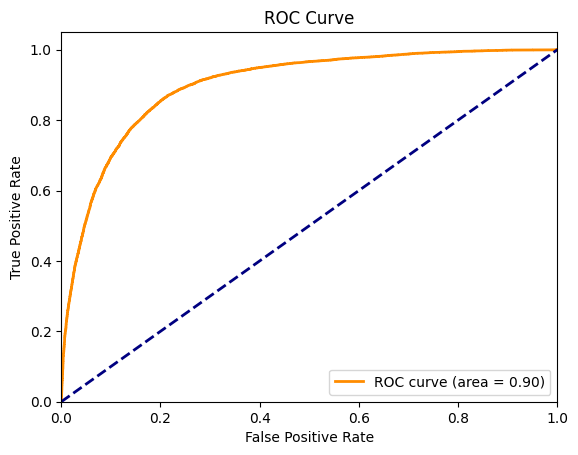

In [14]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:
'''

The BIAS columns that need to be fair:

 25  applicant_sex                             143288 non-null  int32  
 26  co_applicant_sex                          143288 non-null  int32  
 27  applicant_age                             143288 non-null  int32  
 28  co_applicant_age                          143288 non-null  int32  
 30  applicant_race_1                          143288 non-null  float32
 31  applicant_race_2                          143288 non-null  float32
 32  co_applicant_race_1                       143288 non-null  float32
 33  co_applicant_race_2                       143288 non-null  float32
 34  applicant_ethnicity_1                     143288 non-null  float32
 35  co_applicant_ethnicity_1
 
 '''



df['co_applicant_ethnicity_1'].value_counts()

co_applicant_ethnicity_1
2.0    141655
1.0      6966
Name: count, dtype: int64

In [16]:
'''

from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming X_min is your minority class data with the specific columns you want to focus on
X_selected = X_min[:, [1, 3, 5]]  # Select columns 1, 3, and 5, for example

# Apply SMOTE only to the selected features
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y_min)

# Concatenate the resampled data with the unchanged columns from the original data
X_resampled_full = np.column_stack((X_min, X_resampled[:, [1, 2]]))  # Assuming you want to keep all columns

'''

"\n\nfrom imblearn.over_sampling import SMOTE\nimport numpy as np\n\n# Assuming X_min is your minority class data with the specific columns you want to focus on\nX_selected = X_min[:, [1, 3, 5]]  # Select columns 1, 3, and 5, for example\n\n# Apply SMOTE only to the selected features\nsmote = SMOTE(sampling_strategy='auto', random_state=42)\nX_resampled, y_resampled = smote.fit_resample(X_selected, y_min)\n\n# Concatenate the resampled data with the unchanged columns from the original data\nX_resampled_full = np.column_stack((X_min, X_resampled[:, [1, 2]]))  # Assuming you want to keep all columns\n\n"

# Gridsearch

In [ ]:
# Step 1: Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'max_iter': [1000, 10000, 100000]  # Maximum number of iterations
}

# Step 2: Create a logistic regression classifier
logistic_reg = LogisticRegression()

# Step 3: Create a GridSearchCV object
grid_search = GridSearchCV(logistic_reg, param_grid, cv=5, scoring='roc_auc')

# Step 4: Fit the GridSearchCV object on your data
grid_search.fit(X_resampled, y_resampled)

# Step 5: Access the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Step 6: Use the best estimator for predictions and evaluation
y_prob_best = best_estimator.predict_proba(X_test)[:, 1]
roc_auc_best = roc_auc_score(y_test, y_prob_best)
print("Best AUC-ROC:", roc_auc_best)

# You can also access other best hyperparameters as needed
print("Best Hyperparameters:", best_params)
